In [1]:
# Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [3]:
pip install qiskit

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 5.0/5.0 MB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 9.6/9.6 MB 2.4 MB/s eta 0:00:00
     -------------------------------------- 241.5/241.5 kB 2.5 MB/s eta 0:00:00
     -------------------------------------- 124.7/124.7 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 56.9/56.9 kB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 49.6/49.6 kB 2.5 MB/s eta 0:00:00
     -----

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
pip install qiskit.ignis

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 198.7/198.7 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

# Import Qiskit classes 
import qiskit
from qiskit import assemble, transpile
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

C:\Users\DELL\AppData\Local\Temp\ipykernel_2716\1536378431.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  import qiskit.ignis.verification.randomized_benchmarking as rb


In [3]:
# Generate RB circuits (2Q RB)

# number of qubits
nQ = 2 
rb_opts = {}
#Number of Cliffords in the sequence
rb_opts['length_vector'] = [1, 10, 20, 50, 75, 100, 125, 150, 175, 200]
# Number of seeds (random sequences)
rb_opts['nseeds'] = 5
# Default pattern
rb_opts['rb_pattern'] = [[0, 1]]

rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [4]:
rb_circs[0][0].draw()

┌───┐┌───┐     ┌─────┐┌───┐                ░                  ┌───┐┌───┐»
qr_0: ┤ Z ├┤ S ├──■──┤ Sdg ├┤ H ├──■─────────────░───────────────■──┤ H ├┤ S ├»
      ├───┤└───┘┌─┴─┐├─────┤├───┤┌─┴─┐┌───┐┌───┐ ░ ┌─────┐┌───┐┌─┴─┐├───┤├───┤»
qr_1: ┤ S ├─────┤ X ├┤ Sdg ├┤ H ├┤ X ├┤ H ├┤ S ├─░─┤ Sdg ├┤ H ├┤ X ├┤ H ├┤ S ├»
      └───┘     └───┘└─────┘└───┘└───┘└───┘└───┘ ░ └─────┘└───┘└───┘└───┘└───┘»
cr: 2/════════════════════════════════════════════════════════════════════════»
                                                                              »
«           ┌─────┐┌───┐┌─┐
«qr_0: ──■──┤ Sdg ├┤ Z ├┤M├
«      ┌─┴─┐├─────┤└┬─┬┘└╥┘
«qr_1: ┤ X ├┤ Sdg ├─┤M├──╫─
«      └───┘└─────┘ └╥┘  ║ 
«cr: 2/══════════════╩═══╩═
«                    1   0

In [5]:
# Create a new circuit without the measurement
qregs = rb_circs[0][-1].qregs
cregs = rb_circs[0][-1].cregs
qc = qiskit.QuantumCircuit(*qregs, *cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc.data.append(i)

In [6]:
# The Unitary is an identity (with a global phase)
sim = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
qc.save_unitary()
unitary = sim.run(qc).result().get_unitary()
from qiskit.visualization import array_to_latex
array_to_latex(unitary, prefix="\\text{Unitary} = ")

<IPython.core.display.Latex object>

In [7]:
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.002
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

backend = qiskit.Aer.get_backend('aer_simulator')

In [8]:
# Create the RB fitter
backend = qiskit.Aer.get_backend('aer_simulator')
basis_gates = ['u1','u2','u3','cx'] 
shots = 200
transpiled_circs_list = []
rb_fit = rb.RBFitter(None, xdata, rb_opts['rb_pattern'])
for rb_seed, rb_circ_seed in enumerate(rb_circs):
    print(f'Compiling seed {rb_seed}')
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    transpiled_circs_list.append(new_rb_circ_seed)
    print(f'Simulating seed {rb_seed}')
    qobj = assemble(new_rb_circ_seed, shots=shots)
    job = backend.run(qobj,
                      noise_model=noise_model,
                      max_parallel_experiments=0)
    # Add data to the fitter
    rb_fit.add_data(job.result())
    print('After seed %d, alpha: %f, EPC: %f'%(rb_seed,rb_fit.fit[0]['params'][1], rb_fit.fit[0]['epc']))

Compiling seed 0
Simulating seed 0
After seed 0, alpha: 0.978052, EPC: 0.016461
Compiling seed 1


C:\Users\DELL\AppData\Local\Temp\ipykernel_2716\3484222176.py:13: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj,


Simulating seed 1
After seed 1, alpha: 0.979945, EPC: 0.015041
Compiling seed 2
Simulating seed 2
After seed 2, alpha: 0.980771, EPC: 0.014422
Compiling seed 3
Simulating seed 3
After seed 3, alpha: 0.981701, EPC: 0.013724
Compiling seed 4
Simulating seed 4
After seed 4, alpha: 0.981416, EPC: 0.013938


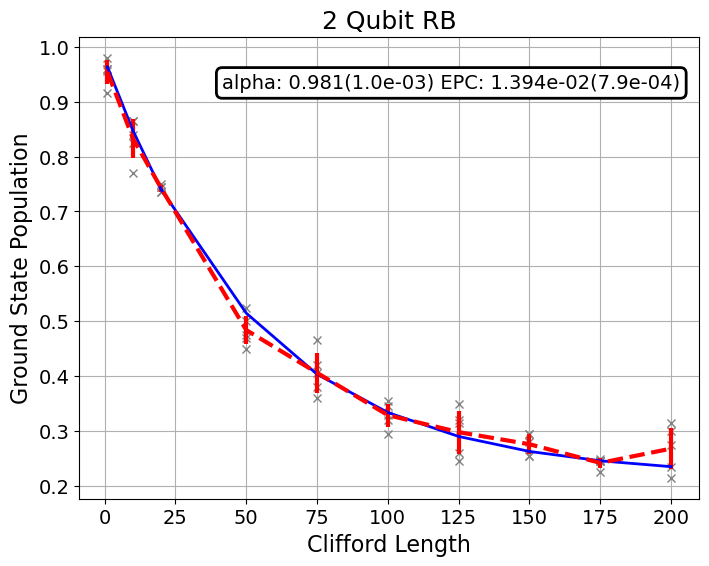

In [9]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(1, 1, 1)

# Plot the essence by calling plot_rb_data
rb_fit.plot_rb_data(0, ax=ax, add_label=True, show_plt=False)
    
# Add title and label
ax.set_title('%d Qubit RB'%(nQ), fontsize=18)

plt.show()

In [10]:
# count the number of single and 2Q gates in the 2Q Cliffords
qubits = rb_opts['rb_pattern'][0]

gate_per_cliff = rb.rb_utils.gates_per_clifford(
    transpiled_circuits_list=transpiled_circs_list,
    clifford_lengths=xdata[0],
    basis=basis_gates,
    qubits=qubits)

for basis_gate in basis_gates:
    print("Number of %s gates per Clifford: %f"%(
        basis_gate,
        np.mean([gate_per_cliff[qubit][basis_gate] for qubit in qubits])))

Number of u1 gates per Clifford: 0.126201
Number of u2 gates per Clifford: 1.659607
Number of u3 gates per Clifford: 0.176092
Number of cx gates per Clifford: 1.500437


In [11]:
# convert from depolarizing error to epg (1Q)
epg_q0 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}
epg_q1 = {'u1': 0, 'u2': p1Q/2, 'u3': 2 * p1Q/2}

# convert from depolarizing error to epg (2Q)
epg_q01 = 3/4 * p2Q

# calculate the predicted epc from underlying gate errors 
pred_epc = rb.rb_utils.calculate_2q_epc(
    gate_per_cliff=gate_per_cliff,
    epg_2q=epg_q01,
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per Clifford: %e (aer simulator result: %e)" % (pred_epc, rb_fit.fit[0]['epc']))

Predicted 2Q Error per Clifford: 1.596996e-02 (aer simulator result: 1.393819e-02)


In [12]:
# use 2Q EPC from aer simulator result and 1Q EPGs from depolarizing error model
pred_epg = rb.rb_utils.calculate_2q_epg(
    gate_per_cliff=gate_per_cliff,
    epc_2q=rb_fit.fit[0]['epc'],
    qubit_pair=qubits,
    list_epgs_1q=[epg_q0, epg_q1])

print("Predicted 2Q Error per gate: %e (gate error model: %e)" % (pred_epg, epg_q01))

Predicted 2Q Error per gate: 6.118331e-03 (gate error model: 7.500000e-03)
